In [30]:
!pip install scipy

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA

data = loadmat('/content/Indian_pines_corrected.mat')['indian_pines_corrected']
gt = loadmat('/content/Indian_pines_gt.mat')['indian_pines_gt']

In [32]:
H, W, B = data.shape
X = data.reshape(-1, B)
y = gt.ravel()

mask = y > 0
X_valid = X[mask]
y_valid = y[mask]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_valid)

print("Data shape (pixels, bands):", X_scaled.shape)
print("Number of valid pixels:", len(y_valid))
print("Unique classes:", np.unique(y_valid))

Data shape (pixels, bands): (10249, 200)
Number of valid pixels: 10249
Unique classes: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


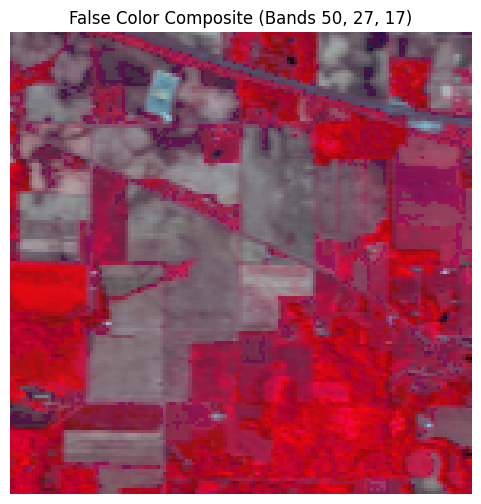

In [33]:
fcc = np.stack([data[:, :, 50], data[:, :, 27], data[:, :, 17]], axis=2)
fcc_norm = (fcc - fcc.min()) / (fcc.max() - fcc.min())

plt.figure(figsize=(6, 6))
plt.imshow(fcc_norm)
plt.title("False Color Composite (Bands 50, 27, 17)")
plt.axis('off')
plt.show()

KMeans Clustering Metrics:
Adjusted Rand Index (ARI): 0.2180
Normalized Mutual Information (NMI): 0.4404
Silhouette Score: 0.2413
Clustering Accuracy (after alignment): 0.3638


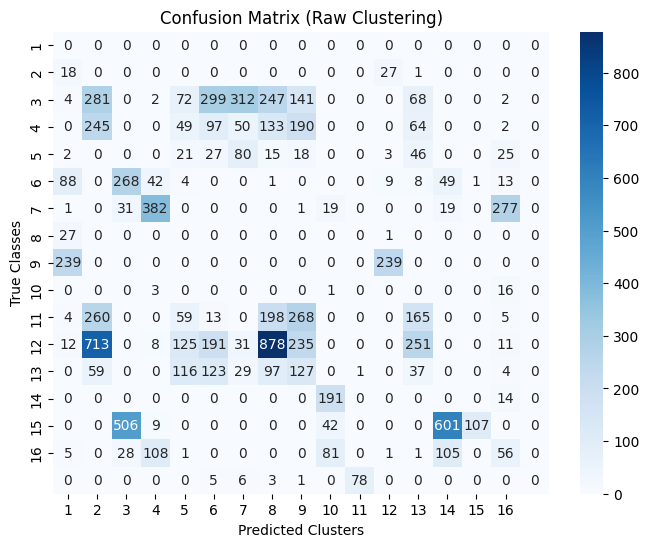

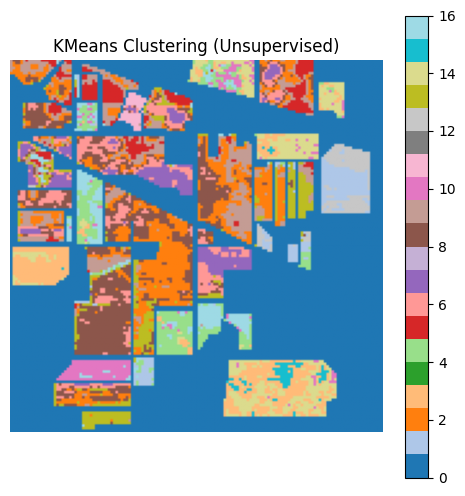

In [36]:
#Kmeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, confusion_matrix
from scipy.optimize import linear_sum_assignment

n_clusters = len(np.unique(y_valid))

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
y_kmeans = kmeans.fit_predict(X_scaled)

ari = adjusted_rand_score(y_valid, y_kmeans)
nmi = normalized_mutual_info_score(y_valid, y_kmeans)
sil_score = silhouette_score(X_scaled, y_kmeans)
print("KMeans Clustering Metrics:")
print("Adjusted Rand Index (ARI): {:.4f}".format(ari))
print("Normalized Mutual Information (NMI): {:.4f}".format(nmi))
print("Silhouette Score: {:.4f}".format(sil_score))

cm = confusion_matrix(y_valid, y_kmeans)

row_ind, col_ind = linear_sum_assignment(-cm)
clustering_accuracy = cm[row_ind, col_ind].sum() / np.sum(cm)
print("Clustering Accuracy (after alignment): {:.4f}".format(clustering_accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.arange(1, n_clusters+1),
            yticklabels=np.arange(1, n_clusters+1))
plt.xlabel("Predicted Clusters")
plt.ylabel("True Classes")
plt.title("Confusion Matrix (Raw Clustering)")
plt.show()

kmeans_image = np.zeros_like(y)
kmeans_image[mask] = y_kmeans + 1
plt.figure(figsize=(6, 6))
plt.imshow(kmeans_image.reshape(H, W), cmap='tab20')
plt.title("KMeans Clustering (Unsupervised)")
plt.axis('off')
plt.colorbar()
plt.show()


=== Supervised Classification (Raw Data) ===
Accuracy: 0.8663
Confusion Matrix:
[[  9   0   0   0   0   0   0   5   0   0   0   0   0   0   0   0]
 [  0 345   4   0   0   2   0   1   0  22  47   7   0   0   0   0]
 [  0  16 171   7   0   0   0   0   0   2  42  11   0   0   0   0]
 [  0   9   4  47   0   3   0   1   0   1   3   3   0   0   0   0]
 [  0   0   0   0 131   3   0   0   0   0   1   3   0   6   1   0]
 [  0   0   0   0   1 212   0   0   0   0   0   0   0   0   6   0]
 [  0   0   0   0   1   0   7   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   2   0   0 141   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   4   0   0   2   0   0   0   0   0   0   0]
 [  0   4   2   0   0   0   0   0   0 258  25   3   0   0   0   0]
 [  0  15  10   1   0   2   0   0   0  18 682   7   0   0   2   0]
 [  0   5   3   3   0   0   0   0   0   3  23 140   0   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  58   0   3   0]
 [  0   0   0   0   2   1   0   0   0   0   0   0

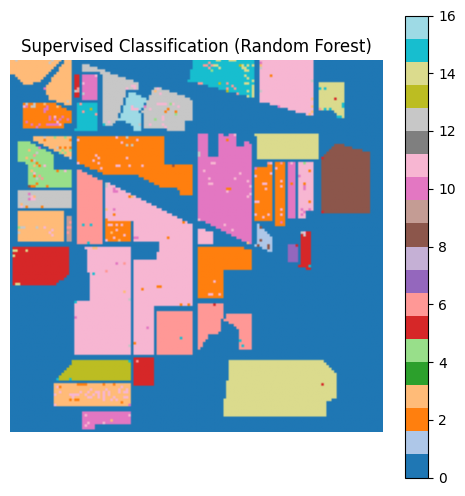

In [23]:
# Supervised Classification
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_valid,
                                                    test_size=0.3, stratify=y_valid, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc_sup = accuracy_score(y_test, y_pred)
cm_sup = confusion_matrix(y_test, y_pred)
report_sup = classification_report(y_test, y_pred)
print("=== Supervised Classification (Raw Data) ===")
print("Accuracy: {:.4f}".format(acc_sup))
print("Confusion Matrix:")
print(cm_sup)
print("Classification Report:")
print(report_sup)

y_full_pred = clf.predict(X_scaled)
sup_image = np.zeros_like(y)
sup_image[mask] = y_full_pred

plt.figure(figsize=(6, 6))
plt.imshow(sup_image.reshape(H, W), cmap='tab20')
plt.title("Supervised Classification (Random Forest)")
plt.axis('off')
plt.colorbar()
plt.show()


=== Anomaly Detection ===
Original valid pixels: 10249
Remaining pixels after removal: 10146
Number of outliers removed: 103


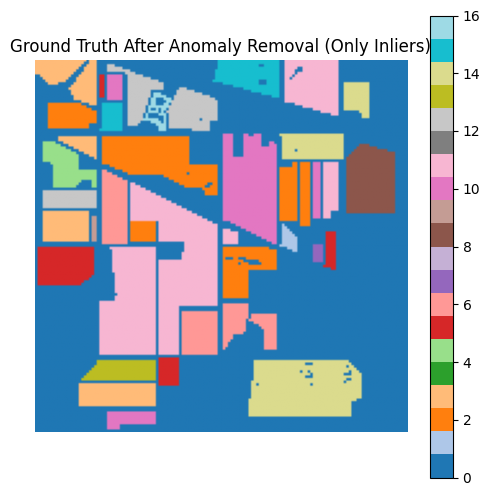

In [44]:
#Anamoly Detection
iso = IsolationForest(contamination=0.01, random_state=42)
inlier_mask = iso.fit_predict(X_scaled) == 1

X_clean = X_scaled[inlier_mask]
y_clean = y_valid[inlier_mask]

print("\n=== Anomaly Detection ===")
print("Original valid pixels:", len(y_valid))
print("Remaining pixels after removal:", len(y_clean))
print("Number of outliers removed:", len(y_valid) - len(y_clean))

clean_image = np.zeros_like(y)
valid_indices = np.where(mask)[0]
clean_indices = valid_indices[inlier_mask]
clean_image[clean_indices] = y_valid[inlier_mask]

plt.figure(figsize=(6, 6))
plt.imshow(clean_image.reshape(H, W), cmap='tab20')
plt.title("Ground Truth After Anomaly Removal (Only Inliers)")
plt.axis('off')
plt.colorbar()
plt.show()


=== Supervised Classification After Anomaly Removal ===
Accuracy: 0.8597
Confusion Matrix:
[[  9   0   0   0   0   0   0   5   0   0   0   0   0   0   0   0]
 [  0 345   2   2   1   1   0   1   0  26  37   7   0   0   0   0]
 [  0  13 172   8   0   0   0   0   0   1  42  13   0   0   0   0]
 [  0   5   5  38   0   1   0   1   0   1   7   9   0   0   0   0]
 [  0   0   0   1 134   2   0   0   0   1   2   2   0   2   1   0]
 [  0   0   0   0   3 215   0   0   0   0   0   0   0   0   1   0]
 [  0   0   0   0   1   0   5   2   0   0   0   0   0   0   0   0]
 [  0   0   0   0   2   0   0 141   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   5   0   0   0   0   0   0   0]
 [  0   5   0   0   1   0   0   0   0 252  31   3   0   0   0   0]
 [  0  23   8   1   2   4   0   0   0  20 670   4   0   0   2   0]
 [  0   9   5   3   0   0   0   0   0   2  25 134   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   1   0  60   0   0   0]
 [  0   0   0   0   0   2   0   0   0

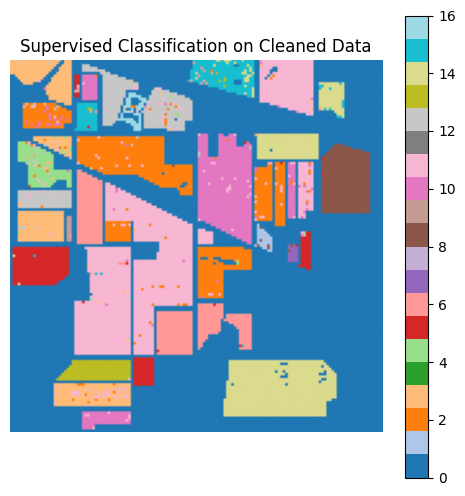


=== Unsupervised Clustering on Cleaned Data ===
Clustering Accuracy (after alignment): 0.3597
Confusion Matrix (Cleaned Data, Unsupervised):
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  27  18   0   0   0   0   1   0   0   0   0   0   0]
 [186   0 135 223   0   4  62   2 194   0  64   1   0   0 264 270   0]
 [ 51   0 160 134   0   0  44   1  69   0  50   0   0   0  47 274   0]
 [ 24   0  20  13   3   1  25   9  11   0  46   6   0   0  63   1   0]
 [  0   1   2   0   9  66   4  74   1 232   9   0  85   0   0   0   0]
 [  0   9  10   0   0   1   0 551   0  16   0  70  73   0   0   0   0]
 [  0   0   0   0   1  27   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 235 243   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  15   0   0   0   5   0   0   0   0   0]
 [  0   0 240 210   0   5  57   1  32   0 163   0   0   0   0 264   0]
 [ 47   0 213 853   0  11 118  16 277   0 237   0   0   0  18 656   0]
 [ 51 

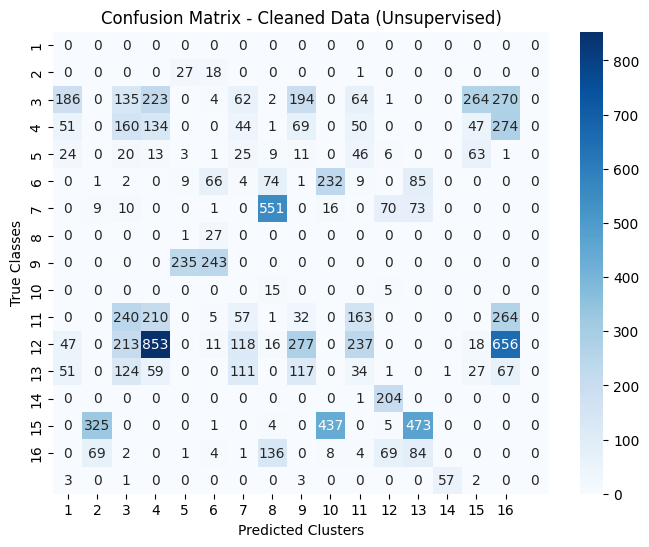

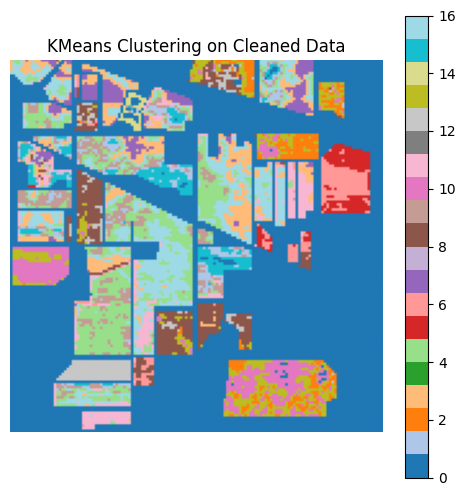

In [37]:
#Sup vs Unsup after Clean
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from scipy.optimize import linear_sum_assignment
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_clean, y_clean,
                                                            test_size=0.3, stratify=y_clean,
                                                            random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_c, y_train_c)
y_pred_clean = clf.predict(X_test_c)
acc_sup_clean = accuracy_score(y_test_c, y_pred_clean)
cm_sup_clean = confusion_matrix(y_test_c, y_pred_clean)
report_sup_clean = classification_report(y_test_c, y_pred_clean)

print("\n=== Supervised Classification After Anomaly Removal ===")
print("Accuracy: {:.4f}".format(acc_sup_clean))
print("Confusion Matrix:")
print(cm_sup_clean)
print("Classification Report:")
print(report_sup_clean)


y_full_pred_clean = clf.predict(X_clean)
sup_clean_image = np.zeros_like(y)
sup_clean_image[clean_indices] = y_full_pred_clean

plt.figure(figsize=(6, 6))
plt.imshow(sup_clean_image.reshape(H, W), cmap='tab20')
plt.title("Supervised Classification on Cleaned Data")
plt.axis('off')
plt.colorbar()
plt.show()


kmeans_clean = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
y_kmeans_clean = kmeans_clean.fit_predict(X_clean)

cm_clean = confusion_matrix(y_clean, y_kmeans_clean)

row_ind, col_ind = linear_sum_assignment(-cm_clean)
clustering_accuracy_clean = cm_clean[row_ind, col_ind].sum() / np.sum(cm_clean)

print("\n=== Unsupervised Clustering on Cleaned Data ===")
print("Clustering Accuracy (after alignment): {:.4f}".format(clustering_accuracy_clean))
print("Confusion Matrix (Cleaned Data, Unsupervised):")
print(cm_clean)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_clean, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.arange(1, n_clusters+1),
            yticklabels=np.arange(1, n_clusters+1))
plt.xlabel("Predicted Clusters")
plt.ylabel("True Classes")
plt.title("Confusion Matrix - Cleaned Data (Unsupervised)")
plt.show()

kmeans_clean_image = np.zeros_like(y)
kmeans_clean_image[clean_indices] = y_kmeans_clean + 1

plt.figure(figsize=(6, 6))
plt.imshow(kmeans_clean_image.reshape(H, W), cmap='tab20')
plt.title("KMeans Clustering on Cleaned Data")
plt.axis('off')
plt.colorbar()
plt.show()


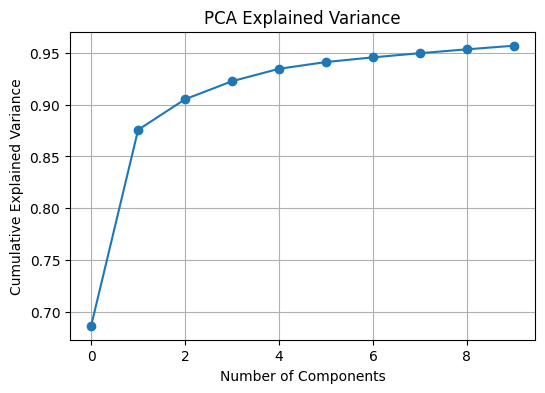

In [27]:
#DR
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.show()


=== Supervised Classification with PCA ===
Accuracy: 0.7954
Confusion Matrix:
[[  6   0   0   0   0   0   0   8   0   0   0   0   0   0   0   0]
 [  0 317   4   3   0   1   0   0   1  24  64  14   0   0   0   0]
 [  0  11 165   3   0   0   0   0   0   2  54  14   0   0   0   0]
 [  0  13   7  34   0   1   0   3   0   0   8   5   0   0   0   0]
 [  0   1   0   1 121   2   0   0   0   0   2   1   0  12   4   1]
 [  0   0   0   1   0 202   0   0   0   0   1   0   0   2  13   0]
 [  0   0   0   0   1   0   6   1   0   0   0   0   0   0   0   0]
 [  0   0   0   0   2   0   0 141   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   4   0   0   0   1   0   1   0]
 [  0  11   4   2   0   0   0   0   0 235  39   1   0   0   0   0]
 [  0  41  11   3   0   4   0   0   0  30 636  11   0   0   1   0]
 [  0  34   8   3   1   0   0   0   0  12  32  87   0   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  58   0   3   0]
 [  0   0   0   0   3   3   0   0   0   0   0   0 

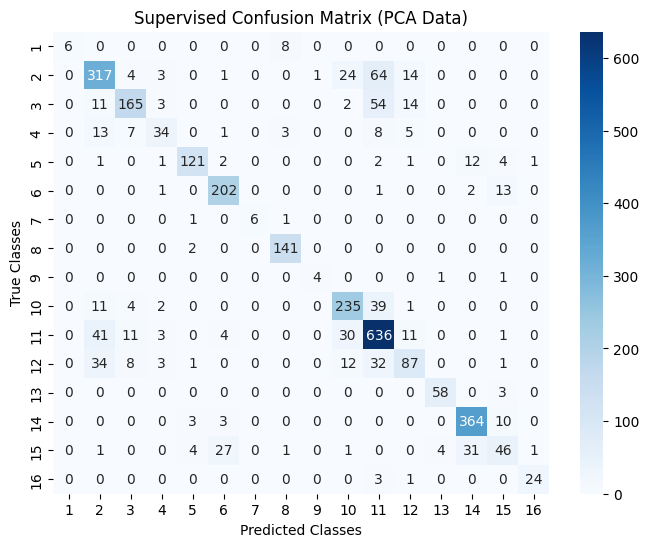

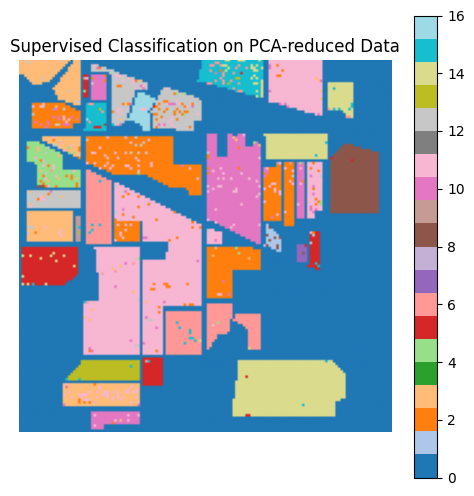


=== Unsupervised Clustering on PCA-reduced Data ===
Clustering Accuracy (after alignment): 0.3662
Confusion Matrix (Raw Clustering on PCA Data):
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 45   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0]
 [  2   0 251   1 212 204  11  59 115   0   3   0 203 167 109  91   0]
 [  0   0 226   1  67  39  22  38 180   0   0   0 134  51  63   9   0]
 [  3   0   3  11  11  42   3  46   3   0   1   0  13  23  40  38   0]
 [ 26  48   0   1   1   0   1  16   0 270 114   0   0   0   6   0   0]
 [  0  40   0 215   0   0   0   1   0  31 413   0   0   0  30   0   0]
 [ 26   0   0   0   0   0   0   2   0   0   0   0   0   0   0   0   0]
 [469   0   0   0   0   0   0   8   0   0   1   0   0   0   0   0   0]
 [  0   0   0   8   0   0   0   0   0   0  12   0   0   0   0   0   0]
 [  1   0 212   0  43   0   5 162 268   0   1   0 188   0  92   0   0]
 [  4   0 639   0 281  20  79 218 218   0  16   0 834  46  92   8   0]
 [

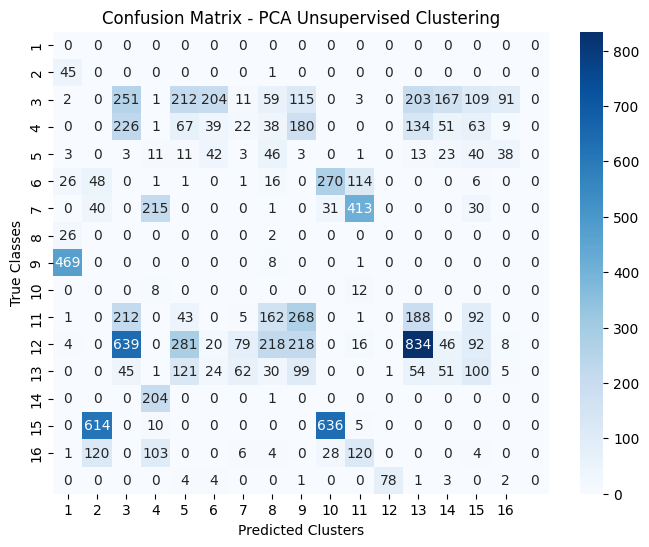

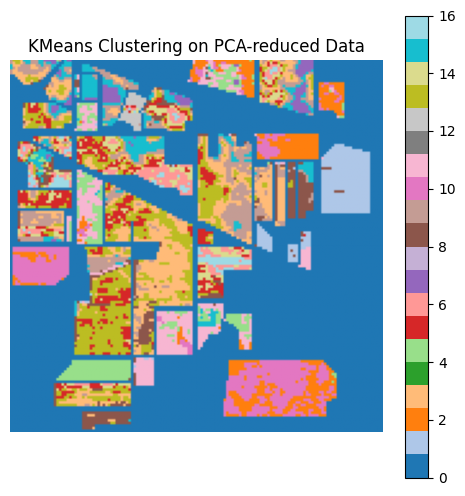

In [38]:
#sup vs unsup after pca
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from scipy.optimize import linear_sum_assignment


X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_pca, y_valid,
                                                            test_size=0.3, stratify=y_valid,
                                                            random_state=42)
clf.fit(X_train_p, y_train_p)
y_pred_pca = clf.predict(X_test_p)
acc_sup_pca = accuracy_score(y_test_p, y_pred_pca)
cm_sup_pca = confusion_matrix(y_test_p, y_pred_pca)
report_sup_pca = classification_report(y_test_p, y_pred_pca)

print("\n=== Supervised Classification with PCA ===")
print("Accuracy: {:.4f}".format(acc_sup_pca))
print("Confusion Matrix:")
print(cm_sup_pca)
print("Classification Report:")
print(report_sup_pca)

plt.figure(figsize=(8,6))
sns.heatmap(cm_sup_pca, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.arange(1, n_clusters+1),
            yticklabels=np.arange(1, n_clusters+1))
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.title("Supervised Confusion Matrix (PCA Data)")
plt.show()

y_full_pred_pca = clf.predict(X_pca)
pca_image = np.zeros_like(y)
pca_image[mask] = y_full_pred_pca

plt.figure(figsize=(6,6))
plt.imshow(pca_image.reshape(H, W), cmap='tab20')
plt.title("Supervised Classification on PCA-reduced Data")
plt.axis('off')
plt.colorbar()
plt.show()



kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
y_kmeans_pca = kmeans_pca.fit_predict(X_pca)

cm_pca = confusion_matrix(y_valid, y_kmeans_pca)

row_ind, col_ind = linear_sum_assignment(-cm_pca)
clustering_accuracy_pca = cm_pca[row_ind, col_ind].sum() / np.sum(cm_pca)
print("\n=== Unsupervised Clustering on PCA-reduced Data ===")
print("Clustering Accuracy (after alignment): {:.4f}".format(clustering_accuracy_pca))
print("Confusion Matrix (Raw Clustering on PCA Data):")
print(cm_pca)

plt.figure(figsize=(8,6))
sns.heatmap(cm_pca, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.arange(1, n_clusters+1),
            yticklabels=np.arange(1, n_clusters+1))
plt.xlabel("Predicted Clusters")
plt.ylabel("True Classes")
plt.title("Confusion Matrix - PCA Unsupervised Clustering")
plt.show()

kmeans_pca_image = np.zeros_like(y)
kmeans_pca_image[mask] = y_kmeans_pca + 1

plt.figure(figsize=(6,6))
plt.imshow(kmeans_pca_image.reshape(H, W), cmap='tab20')
plt.title("KMeans Clustering on PCA-reduced Data")
plt.axis('off')
plt.colorbar()
plt.show()


In [42]:
print("Summary of Accuracies:")
print("Supervised (Raw): {:.4f}".format(acc_sup))
print("Supervised (Cleaned): {:.4f}".format(acc_sup_clean))
print("Supervised (with PCA): {:.4f}".format(acc_sup_pca))

print("Unsupervised (Raw): {:.4f}".format(0.3638))
print("Unsupervised (Cleaned): {:.4f}".format(0.3597))
print("UnSupervised (with PCA): {:.4f}".format(0.3662))

Summary of Accuracies:
Supervised (Raw): 0.8663
Supervised (Cleaned): 0.8597
Supervised (with PCA): 0.7954
Unsupervised (Raw): 0.3638
Unsupervised (Cleaned): 0.3597
UnSupervised (with PCA): 0.3662


Data loaded and preprocessed
Shape of standardized valid data:  (10249, 200)
Unique classes:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

== Analysis on Raw Standardized Data ==

=== Supervised Classification (Raw Data) ===
Accuracy: 0.8663
Confusion Matrix:
[[  9   0   0   0   0   0   0   5   0   0   0   0   0   0   0   0]
 [  0 345   4   0   0   2   0   1   0  22  47   7   0   0   0   0]
 [  0  16 171   7   0   0   0   0   0   2  42  11   0   0   0   0]
 [  0   9   4  47   0   3   0   1   0   1   3   3   0   0   0   0]
 [  0   0   0   0 131   3   0   0   0   0   1   3   0   6   1   0]
 [  0   0   0   0   1 212   0   0   0   0   0   0   0   0   6   0]
 [  0   0   0   0   1   0   7   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   2   0   0 141   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   4   0   0   2   0   0   0   0   0   0   0]
 [  0   4   2   0   0   0   0   0   0 258  25   3   0   0   0   0]
 [  0  15  10   1   0   2   0   0   0  18 682   7   0   0   2   

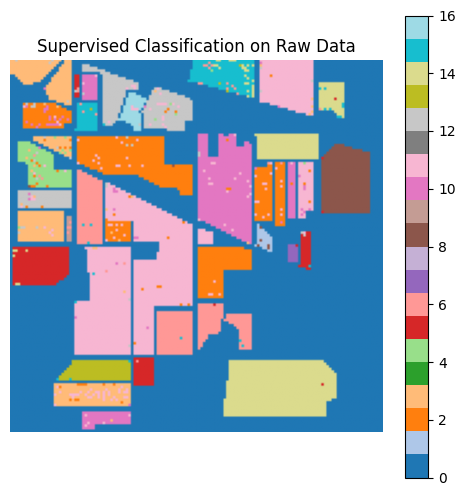

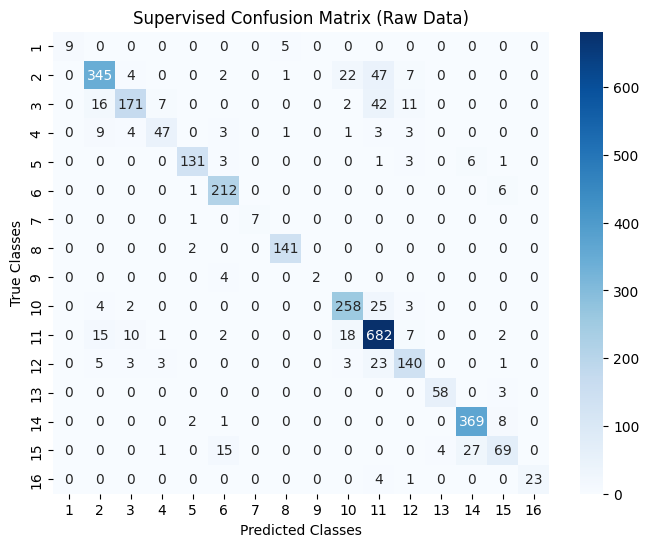


=== Unsupervised Clustering on Raw Data ===
Adjusted Rand Index (ARI): 0.2180
Normalized Mutual Information (NMI): 0.4404
Silhouette Score: 0.2413
Clustering Accuracy (after alignment): 0.3638


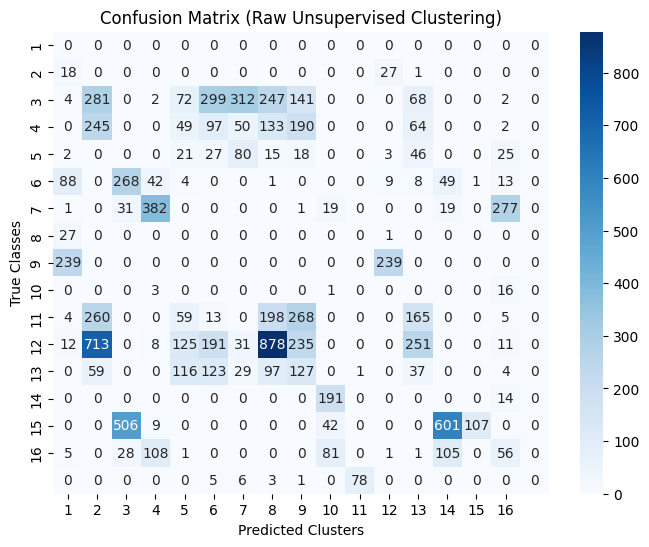

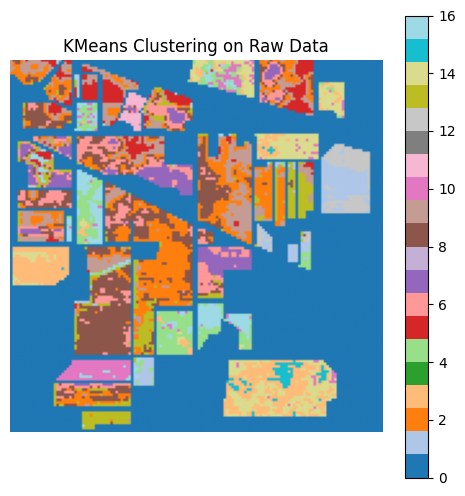


== Analysis on PCA-Reduced Data ==
PCA completed. Explained variance ratio (cumulative): [0.68658669 0.87566144 0.90518907 0.92257626 0.93457845 0.94108513
 0.94561079 0.94961959 0.95335445 0.95683203]

=== Supervised Classification on PCA Data ===
Accuracy: 0.7954
Confusion Matrix:
[[  6   0   0   0   0   0   0   8   0   0   0   0   0   0   0   0]
 [  0 317   4   3   0   1   0   0   1  24  64  14   0   0   0   0]
 [  0  11 165   3   0   0   0   0   0   2  54  14   0   0   0   0]
 [  0  13   7  34   0   1   0   3   0   0   8   5   0   0   0   0]
 [  0   1   0   1 121   2   0   0   0   0   2   1   0  12   4   1]
 [  0   0   0   1   0 202   0   0   0   0   1   0   0   2  13   0]
 [  0   0   0   0   1   0   6   1   0   0   0   0   0   0   0   0]
 [  0   0   0   0   2   0   0 141   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   4   0   0   0   1   0   1   0]
 [  0  11   4   2   0   0   0   0   0 235  39   1   0   0   0   0]
 [  0  41  11   3   0   4   0   0   0  30 636

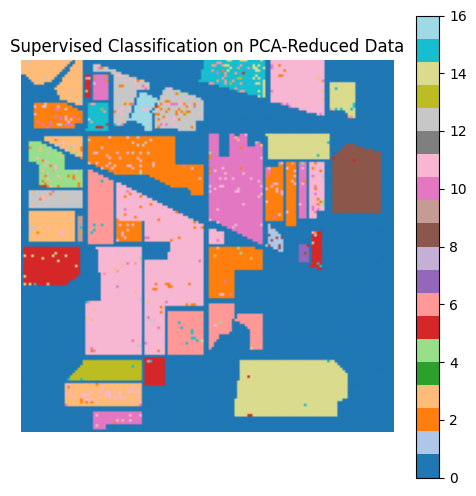

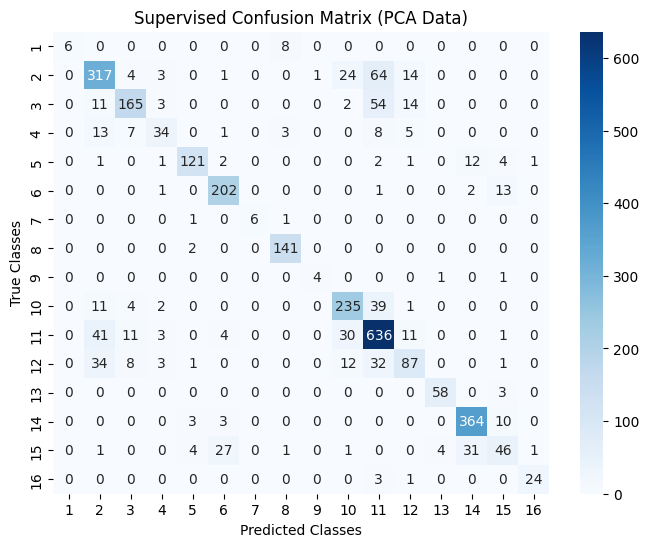


=== Unsupervised Clustering on PCA Data ===
Clustering Accuracy (after alignment): 0.3662
Confusion Matrix (Raw Clustering on PCA Data):
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 45   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0]
 [  2   0 251   1 212 204  11  59 115   0   3   0 203 167 109  91   0]
 [  0   0 226   1  67  39  22  38 180   0   0   0 134  51  63   9   0]
 [  3   0   3  11  11  42   3  46   3   0   1   0  13  23  40  38   0]
 [ 26  48   0   1   1   0   1  16   0 270 114   0   0   0   6   0   0]
 [  0  40   0 215   0   0   0   1   0  31 413   0   0   0  30   0   0]
 [ 26   0   0   0   0   0   0   2   0   0   0   0   0   0   0   0   0]
 [469   0   0   0   0   0   0   8   0   0   1   0   0   0   0   0   0]
 [  0   0   0   8   0   0   0   0   0   0  12   0   0   0   0   0   0]
 [  1   0 212   0  43   0   5 162 268   0   1   0 188   0  92   0   0]
 [  4   0 639   0 281  20  79 218 218   0  16   0 834  46  92   8   0]
 [  0   0 

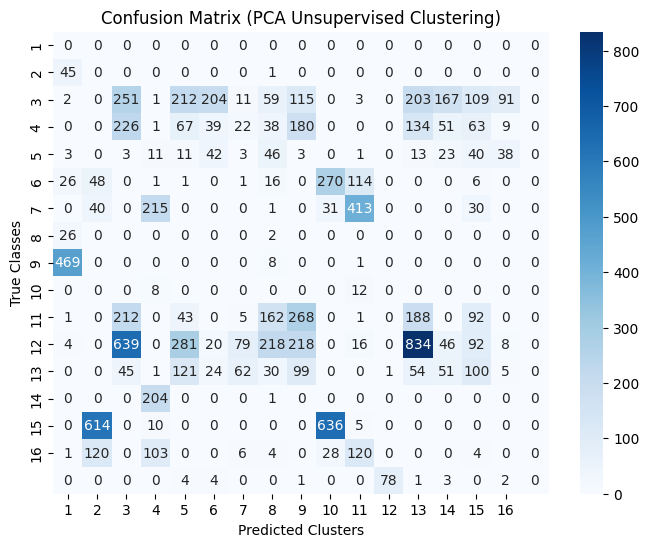

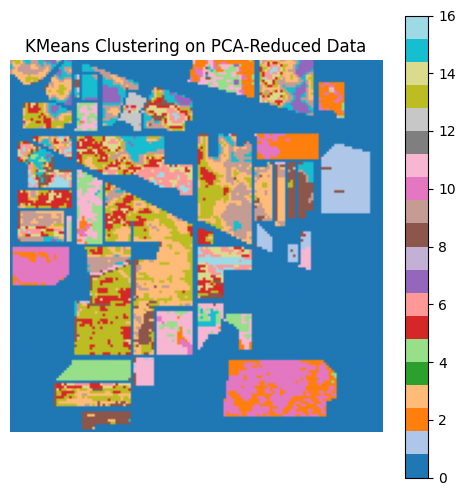


Comparison Summary:
Supervised (Raw Data) Accuracy: 0.8663
Unsupervised (Raw Data) Clustering Accuracy: 0.3638
Supervised (PCA Data) Accuracy: 0.7954
Unsupervised (PCA Data) Clustering Accuracy: 0.3662


In [43]:
#only pca no anomaly

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             adjusted_rand_score, normalized_mutual_info_score, silhouette_score)
from scipy.optimize import linear_sum_assignment

data = loadmat('/content/Indian_pines_corrected.mat')['indian_pines_corrected']
gt = loadmat('/content/Indian_pines_gt.mat')['indian_pines_gt']

H, W, B = data.shape

X = data.reshape(-1, B)
y = gt.ravel()

mask = y > 0
X_valid = X[mask]
y_valid = y[mask]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_valid)

n_clusters = len(np.unique(y_valid))

print("Data loaded and preprocessed")
print("Shape of standardized valid data: ", X_scaled.shape)
print("Unique classes: ", np.unique(y_valid))



print("\n===================================")
print("== Analysis on Raw Standardized Data ==")
print("===================================")

# ---- Supervised Classification on Raw Data ----
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_valid,
                                                    test_size=0.3, stratify=y_valid, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred_sup = clf.predict(X_test)
acc_sup = accuracy_score(y_test, y_pred_sup)
cm_sup = confusion_matrix(y_test, y_pred_sup)
report_sup = classification_report(y_test, y_pred_sup)

print("\n=== Supervised Classification (Raw Data) ===")
print("Accuracy: {:.4f}".format(acc_sup))
print("Confusion Matrix:")
print(cm_sup)
print("Classification Report:\n", report_sup)

# Reconstruct supervised prediction for full image
y_full_sup = clf.predict(X_scaled)
sup_image = np.zeros_like(y)
sup_image[mask] = y_full_sup

plt.figure(figsize=(6, 6))
plt.imshow(sup_image.reshape(H, W), cmap='tab20')
plt.title("Supervised Classification on Raw Data")
plt.axis('off')
plt.colorbar()
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(cm_sup, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.arange(1, n_clusters+1),
            yticklabels=np.arange(1, n_clusters+1))
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.title("Supervised Confusion Matrix (Raw Data)")
plt.show()

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
y_kmeans = kmeans.fit_predict(X_scaled)

ari = adjusted_rand_score(y_valid, y_kmeans)
nmi = normalized_mutual_info_score(y_valid, y_kmeans)
sil_score = silhouette_score(X_scaled, y_kmeans)
print("\n=== Unsupervised Clustering on Raw Data ===")
print("Adjusted Rand Index (ARI): {:.4f}".format(ari))
print("Normalized Mutual Information (NMI): {:.4f}".format(nmi))
print("Silhouette Score: {:.4f}".format(sil_score))

cm_unsup = confusion_matrix(y_valid, y_kmeans)
row_ind, col_ind = linear_sum_assignment(-cm_unsup)
clustering_accuracy = cm_unsup[row_ind, col_ind].sum() / np.sum(cm_unsup)
print("Clustering Accuracy (after alignment): {:.4f}".format(clustering_accuracy))

plt.figure(figsize=(8,6))
sns.heatmap(cm_unsup, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.arange(1, n_clusters+1),
            yticklabels=np.arange(1, n_clusters+1))
plt.xlabel("Predicted Clusters")
plt.ylabel("True Classes")
plt.title("Confusion Matrix (Raw Unsupervised Clustering)")
plt.show()

kmeans_image = np.zeros_like(y)
kmeans_image[mask] = y_kmeans + 1
plt.figure(figsize=(6, 6))
plt.imshow(kmeans_image.reshape(H, W), cmap='tab20')
plt.title("KMeans Clustering on Raw Data")
plt.axis('off')
plt.colorbar()
plt.show()



print("\n====================================")
print("== Analysis on PCA-Reduced Data ==")
print("====================================")

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)
print("PCA completed. Explained variance ratio (cumulative):", np.cumsum(pca.explained_variance_ratio_))

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_pca, y_valid,
                                                            test_size=0.3, stratify=y_valid, random_state=42)
clf.fit(X_train_p, y_train_p)
y_pred_sup_pca = clf.predict(X_test_p)
acc_sup_pca = accuracy_score(y_test_p, y_pred_sup_pca)
cm_sup_pca = confusion_matrix(y_test_p, y_pred_sup_pca)
report_sup_pca = classification_report(y_test_p, y_pred_sup_pca)

print("\n=== Supervised Classification on PCA Data ===")
print("Accuracy: {:.4f}".format(acc_sup_pca))
print("Confusion Matrix:")
print(cm_sup_pca)
print("Classification Report:\n", report_sup_pca)

y_full_sup_pca = clf.predict(X_pca)
pca_image = np.zeros_like(y)
pca_image[mask] = y_full_sup_pca

plt.figure(figsize=(6,6))
plt.imshow(pca_image.reshape(H, W), cmap='tab20')
plt.title("Supervised Classification on PCA-Reduced Data")
plt.axis('off')
plt.colorbar()
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(cm_sup_pca, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.arange(1, n_clusters+1),
            yticklabels=np.arange(1, n_clusters+1))
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.title("Supervised Confusion Matrix (PCA Data)")
plt.show()

kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
y_kmeans_pca = kmeans_pca.fit_predict(X_pca)

cm_unsup_pca = confusion_matrix(y_valid, y_kmeans_pca)
row_ind_pca, col_ind_pca = linear_sum_assignment(-cm_unsup_pca)
clustering_accuracy_pca = cm_unsup_pca[row_ind_pca, col_ind_pca].sum() / np.sum(cm_unsup_pca)
print("\n=== Unsupervised Clustering on PCA Data ===")
print("Clustering Accuracy (after alignment): {:.4f}".format(clustering_accuracy_pca))
print("Confusion Matrix (Raw Clustering on PCA Data):")
print(cm_unsup_pca)

plt.figure(figsize=(8,6))
sns.heatmap(cm_unsup_pca, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.arange(1, n_clusters+1),
            yticklabels=np.arange(1, n_clusters+1))
plt.xlabel("Predicted Clusters")
plt.ylabel("True Classes")
plt.title("Confusion Matrix (PCA Unsupervised Clustering)")
plt.show()

kmeans_pca_image = np.zeros_like(y)
kmeans_pca_image[mask] = y_kmeans_pca + 1  # add 1 to ensure label > 0
plt.figure(figsize=(6,6))
plt.imshow(kmeans_pca_image.reshape(H, W), cmap='tab20')
plt.title("KMeans Clustering on PCA-Reduced Data")
plt.axis('off')
plt.colorbar()
plt.show()


print("\n========================")
print("Comparison Summary:")
print("========================")
print("Supervised (Raw Data) Accuracy: {:.4f}".format(acc_sup))
print("Unsupervised (Raw Data) Clustering Accuracy: {:.4f}".format(clustering_accuracy))
print("Supervised (PCA Data) Accuracy: {:.4f}".format(acc_sup_pca))
print("Unsupervised (PCA Data) Clustering Accuracy: {:.4f}".format(clustering_accuracy_pca))
